<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/MegaDetector/confusion_matrix/02_create-confusion-matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, a 'results' folder is created

results
    |__ 
    
"""

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import os
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
WI_folder = 'My Drive/FFI/Wildlife Insights Bulk Upload Test/bulk-upload_template-autofill/data cleaning'
ground_truth_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/ground-truths'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
MD_result_file_name = 'MegaDetector_result_2021-08-27.json'
# taxon match table is generated using Wildlife Insights/bulk-upload/04_collect-WI-taxon-database.ipynb script
# it is saved as 4.1_collect_WI-taxon-database.csv
taxon_match_table_file_name = '4.1_collect_WI-taxon-database.csv'

In [4]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=False)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

In [34]:
# read ground-truth table
ground_truth_table = read_csv_Google_drive(root, ground_truth_folder, ground_truth_file_name)
id = [i for i in range(len(ground_truth_table))]
ground_truth_table['id'] = id
ground_truth_table[~ ground_truth_table.species_common_name.isna()].head(50)

,FileName,species_common_name,datetime_created,batch_group,id
0,100__67096__2019-04-22__15-09-11(1).JPG,Human,2019-04-22 15:09:11,0,0
1,100__67096__2019-04-22__15-09-42(2).JPG,Human,2019-04-22 15:09:42,1,1
2,100__67096__2019-04-22__15-12-32(1).JPG,Human,2019-04-22 15:12:32,2,2
3,100__67096__2019-04-22__15-12-55(2).JPG,Human,2019-04-22 15:12:55,3,3
4,100__67096__2019-04-22__15-13-18(1).JPG,Human,2019-04-22 15:13:18,4,4
5,100__67096__2019-04-22__15-14-06(1).JPG,Human,2019-04-22 15:14:06,5,5
6,100__67096__2019-04-22__15-14-47(2).JPG,Human,2019-04-22 15:14:47,6,6
7,100__67096__2019-04-22__15-15-23(1).JPG,Human,2019-04-22 15:15:23,7,7
8,100__67096__2019-04-24__09-55-44(1).JPG,Yellow-throated Marten,2019-04-24 09:55:44,8,8
9,100__67096__2019-04-24__09-55-46(2).JPG,Yellow-throated Marten,2019-04-24 09:55:46,8,9


In [18]:
# read MegaDetector result
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

# print sample result
mega_result['images'][5]

{'detections': [{'bbox': [0.5825, 0.9118, 0.4078, 0.08803],
   'category': '1',
   'conf': 0.849},
  {'bbox': [0.003062, 0.8421, 0.1527, 0.1578],
   'category': '1',
   'conf': 0.214}],
 'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/100/67096/100__67096__2019-04-27__12-50-26(3).JPG',
 'max_detection_conf': 0.849}

In [33]:
# read taxon_match_table
taxon_match_table = read_csv_Google_drive(root, WI_folder, taxon_match_table_file_name)
taxon_match_table.sample(5)

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name
61,2003056,Mammalia,Cetartiodactyla,Cervidae,Muntiacus,vaginalis,"Boddaert, 1785",Northern Red Muntjac,biological,9e90f0ba-0009-490b-b975-55829245a28e,Northern Red Muntjac
136,2021556,NaN,NaN,NaN,NaN,NaN,NaN,Blank,object,f1856211-cfb7-4a5b-9158-c0f72fd09ee6,Blank
99,2009725,Aves,Piciformes,Picidae,Picus,rabieri,"Oustalet, 1898",Red-collared Woodpecker,biological,6cd3d89b-83db-4627-b837-ee65c61a010f,Red-collared Woodpecker
40,2021317,Mammalia,Rodentia,Sciuridae,NaN,NaN,NaN,Sciuridae Family,biological,e4d1e892-0e4b-475a-a8ac-b5c3502e0d55,Squirrel
114,2008296,Aves,Charadriiformes,Scolopacidae,Scolopax,rusticola,"Linnaeus, 1758",Eurasian Woodcock,biological,b77d7237-243a-490e-b547-90e52983c23a,Eurasian Woodcock


In [35]:
# sanity check file consistency between MD results and ground-truth data
in_ground_truth_not_MD = []
in_MD_not_ground_truth = []

list_of_MD_filename = []
for i in range(len(mega_result['images'])):
  list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

list_of_ground_truth_filename = ground_truth_table['FileName'].to_list()

count_1 = 0
for i in tqdm(range(len(list_of_ground_truth_filename))):
  filename = list_of_ground_truth_filename[i]
  if filename in list_of_MD_filename:
    continue
  count_1 += 1
  in_ground_truth_not_MD.append(filename)

count_2 = 0
for i in tqdm(range(len(mega_result['images']))):
  filename = list_of_MD_filename[i]
  if filename in list_of_ground_truth_filename:
    continue
  count_2 += 1
  in_MD_not_ground_truth.append(filename)

with open('in_ground_truth_not_MD.txt', 'w') as f:
  for i in in_ground_truth_not_MD:
    f.write(i + '\n')
print(f'There are {count_1} files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.')

with open('in_MD_not_ground_truth.txt', 'w') as f:
  for i in in_MD_not_ground_truth:
    f.write(i + '\n')
print(f'There are {count_2} files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.')


# update ground truth table to contain only files in both
print(f'Ground-truth table original size {len(ground_truth_table)}')
ground_truth_table = ground_truth_table[~ ground_truth_table['FileName'].isin(in_ground_truth_not_MD)]
print(f'Ground-truth table updated size  {len(ground_truth_table)}')

  0%|          | 0/110318 [00:00<?, ?it/s]

  0%|          | 0/110166 [00:00<?, ?it/s]

There are 9243 files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.
There are 9174 files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.
Ground-truth table original size 110318
Ground-truth table updated size  101075


In [36]:
def list_labels(mega_result, ground_truth_table, threshold, in_batch=True):
  """
  list actual labels and prediction labels
  @params in_batch: accounts for images in batch. For example if 3 images in a 
                    batch has 3 animals, but MD could detect only one, that 
                    would be enough to be a correct detection.
  @return: a list of actual labels and a list of predection labels
  """

  def has_any_object_in_batch(detection_batch, threshold, category_id):
    for detection in detection_batch:
      for i in range(len(detection)):
        if detection[i]['conf'] > threshold and detection[i]['category'] == category_id:
          return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  list_of_MD_filename = []
  for i in range(len(mega_result['images'])):
    list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  # get number of batches
  # num_batch = ground_truth_table['batch_group'].nunique()

  y_actu = []
  y_pred = []

  if in_batch:
    # num_row = num_batch
    column_in_search = ground_truth_table['batch_group']
    column_name = 'batch_group'
  else:
    # num_row = len(ground_truth_table)
    column_in_search = ground_truth_table['id']
    column_name = 'id'

  """
  treat each batch as an image
  # in case batch is blank
  if all rows are blank:
    if all predictions are blank:
      actu.append('Blank')
      pred.append('Blank')
    if there is at least one animal in predictions:
      actu.append('Blank')
      pred.append('Animal')

  # in case batch is not blank
  if there are n distinct animals, e.g. Human and Domestic Dog:
    for each distinct animal
      if any of that animal is correctly detected:
        actu.append(distinct_animal)
        pred.append(animal)
      else:
        actu.append(distinct_animal)
        pred.append('Blank')
  """
  for i in tqdm(range(len(column_in_search.unique()))):
    sub_table = ground_truth_table[ground_truth_table[column_name] == column_in_search.iat[i]]

    filenames = sub_table['FileName'].to_list()

    # store list of detections for the batch
    detection_batch = []

    for f in filenames:
      try:
        detection = mega_result['images'][list_of_MD_filename.index(f)]['detections']
        detection_batch.append(detection)
      except Exception as e:
        # print(str(e))
        print(mega_result['images'][list_of_MD_filename.index(f)])
        
    # if all images are blank
    if sub_table['species_common_name'].isnull().sum() == len(sub_table):
      # if any Human is detected
      if has_any_object_in_batch(detection_batch, threshold, '2'):
        y_actu.append('Blank')
        y_pred.append('Human')
      # if any Animal is detected
      elif has_any_object_in_batch(detection_batch, threshold, '1'):
        y_actu.append('Blank')
        y_pred.append('Animal')
      else:
        y_actu.append('Blank')
        y_pred.append('Blank')

    # if there is at least one detection event
    else:
      # list n distinct animal detections
      distinct_animals = sub_table['species_common_name'].unique()

      for animal in distinct_animals:
        if animal == 'Human':
          if has_any_object_in_batch(detection_batch, threshold, '2'):
            y_actu.append('Human')
            y_pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, '1'):
            y_actu.append('Human')
            y_pred.append('Animal')
          else:
            y_actu.append('Human')
            y_pred.append('Blank')
        else:
          if has_any_object_in_batch(detection_batch, threshold, '2'):
            y_actu.append(animal)
            y_pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, '1'):
            y_actu.append(animal)
            y_pred.append(animal)
          else:
            y_actu.append(animal)
            y_pred.append('Blank')

  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred

y_actu_test, y_pred_test = list_labels(mega_result, ground_truth_table, 0.5, in_batch=True)

110166 images
Generating actual and prediction lists...


  0%|          | 0/79939 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


In [ ]:
#@title temporary hidden
def list_labels(mega_result, ground_truth_table, THRESHOLD):
  """
  list actual labels and prediction labels
  """

  def has_object(detections, threshold, category_id):
    for i in range(len(detections)):
      if detections[i]['conf'] > threshold and detections[i]['category'] == category_id:
        return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  files = []
  for i in range(len(mega_result['images'])):
    files.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  y_actu = []
  y_pred = []

  count = 0

  for i in tqdm(range(len(ground_truth_table))):
    try:
      # actual label
      actu = ground_truth_table['species_common_name'].iat[i]

      filename = ground_truth_table['FileName'].iat[i]

      # prediction label

      # if the image has any human
      if has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2'):
        y_pred.append('Human')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)
      # if the image has any animal
      elif has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1'):
        if str(actu) == 'nan':
          y_pred.append('Animal')
          y_actu.append('Blank')
        else:
          y_pred.append(actu)
          y_actu.append(actu)

      # if not have any human or animal
      elif (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1')) and (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2')):
        y_pred.append('Blank')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)    
    except Exception as e:
      count += 1
      # print(str(e))
      pass
  print(count)
  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred


y_actu_ground, y_pred_ground = list_labels(mega_result, ground_truth_table, 0.5)

110166 images
Generating actual and prediction lists...


  0%|          | 0/110318 [00:00<?, ?it/s]

9263
Reduction rate 0.7793676710702093


In [ ]:
print('ground', len(y_actu_ground))
print('test  ', len(y_actu_test))

print('ground', len(y_pred_ground))
print('test  ', len(y_pred_test))

print(y_actu_test == y_actu_ground)

for i in range(len(y_pred_test)):
  if y_pred_test[i] != y_pred_ground[i]:

    print(y_pred_test[i], y_pred_ground[i])

# pd.DataFrame({'y_actu_ground':y_actu_ground, 'y_actu_test': y_actu_test})
# pd.DataFrame({'y_pred_ground':y_pred_ground, 'y_pred_test': y_pred_test}).to_csv('prediction.csv')

ground 101055
test   101055
ground 101055
test   101055


In [51]:
def get_taxonomy(species_common_name, level, taxon_match_table):
  """
  get taxonomical class level of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    taxon_class = row[level.lower()].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return taxon_class

# test
get_taxonomy('Annamite Dark Muntjac', 'family', taxon_match_table)

'Cervidae'

In [65]:
taxon_match_table[taxon_match_table['FFI_species_name'] == 'Annamite Dark Muntjac']

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name
51,2003055,Mammalia,Cetartiodactyla,Cervidae,Muntiacus,truongsonensis,"Giao, Tuoc, Dung, Wikramanayake, Amato, Arctan...",Annamite Muntjac,biological,a0dc30c3-acf6-4d21-a8f8-3edaffd1de3b,Annamite Dark Muntjac


In [45]:
def get_scientific_name(species_common_name, taxon_match_table):
  """
  get genus and species name of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    genus, species = row['genus'].iat[0], row['species'].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return genus, species

# test
get_scientific_name("Owston's Civet", taxon_match_table)

('Chrotogale', 'owstoni')

In [46]:
def get_conservation_status(genus, species):
  """
  get consevation status of a species from IUCN red list API
  https://apiv3.iucnredlist.org/api/v3/docs#species-history-name
  """
  api_token = "eba8c1a83a9d25e8ff01b8acbfa153fe3317d90badd60e2ec1d87ac8b330fda6"
  response = requests.get(f"https://apiv3.iucnredlist.org/api/v3/species/history/name/{genus}%20{species}?token={api_token}")
  try:
    status = response.json()['result'][0]['category']
  except:
    print('     Can not find conservation status for', genus, species)
  return status

# test
get_conservation_status('Chrotogale', 'owstoni')

'Endangered'

In [60]:
def create_confusion_matrix(y_actu, y_pred):
  print('Generating confusion matrix...')

  y_actu = pd.Series(y_actu, name='Actual')
  y_pred = pd.Series(y_pred, name='Prediction')
  df_confusion = pd.crosstab(y_pred, y_actu, rownames=['Prediction'], colnames=['Actual'], margins=True)

  # collapse rows
  confusion_matrix = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for col in df_confusion.columns:
    all = df_confusion[col]['All']
    animal = all - df_confusion[col]['Blank'] - df_confusion[col]['Human']
    human = df_confusion[col]['Human']
    blank = df_confusion[col]['Blank']
    total = animal + human + blank
    confusion_matrix[col] = [str(animal), str(human), str(blank), str(total), ''] # leave a blank cell for recall value
  
  # lump the Murid rodent family
  confusion_matrix['Murid'] = confusion_matrix['Murid'] + confusion_matrix['Leopoldamys'] + confusion_matrix['Maxomys']

  # drop columns 
  confusion_matrix.drop(columns=['All', 'Moth', 'Bat', 'Flying Insect', 'Leopoldamys', 'Maxomys', 'Butterfly'], inplace=True)
  
  # add recall row
  for col in confusion_matrix.columns:
    if col == 'Blank':
      confusion_matrix[col][4] = round(int(confusion_matrix[col][2]) / int(confusion_matrix[col][3]), 2)
    elif col == 'Human':
      confusion_matrix[col][4] = round(int(confusion_matrix[col][1]) / int(confusion_matrix[col][3]), 2)
    else:
      confusion_matrix[col][4] = round(int(confusion_matrix[col][0]) / int(confusion_matrix[col][3]), 2)

  return confusion_matrix

confusion_matrix = create_confusion_matrix(y_actu_test, y_pred_test)


Generating confusion matrix...


In [99]:
def create_confusion_matrix_by_group(confusion_matrix, species_group):
  """
  create a confusion matrix by species group, e.g. "ungulates", "small carnivores", "birds", "small mammals (squirrels and rats)", "primates"
  @params species_group: dict {group_common_name: [toxonomical_level, group_scientific_name]}
    example: {'Bird':["class", "Aves"], "Small mammals":["order", "Rodentia"]}
  """
  confusion_matrix_by_group = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for group in species_group.keys():
    species_list = find_FFI_species_by_taxonomy(taxon_match_table, 
                                                species_group[group][0], 
                                                species_group[group][1])
    species_list = list(set(species_list) & set(confusion_matrix.columns))
    confusion_matrix_by_group[group] = confusion_matrix[species_list].astype('float').sum(axis = 1) # cast to int to avoid weird behaviors!

  # update recall
  for col in confusion_matrix_by_group.columns:
    if col == 'Human':
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][1]) / int(confusion_matrix_by_group[col][3]), 2)
    else:
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][0]) / int(confusion_matrix_by_group[col][3]), 2)
  return confusion_matrix_by_group

create_confusion_matrix_by_group(confusion_matrix, {'Ungulates':['order', 'Cetartiodactyla'],
                                                    'Bird'     :['class', 'Aves'],
                                                    'Small carnivores':[],
                                                    'Small mammals':[],
                                                    'Primates':[],
                                                    'Bear':[],
                                                    'Pangolin':[],
                                                    'Human':[]
                                                    })

,Ungulates,Bird
Animal,279.00,3554.00
Human,0.00,32.00
Blank,39.00,2168.00
Total,318.00,5754.00
Recall,0.88,0.62


In [79]:
def find_FFI_species_by_taxonomy(taxon_match_table, level, taxonomy):
  """
  returns list of species in a taxonomical group, e.g. class Mammalia, order Rodentia
  """
  sub_df = taxon_match_table[taxon_match_table[level.lower()] == taxonomy]
  
  return sub_df['FFI_species_name'].to_list() 

confusion_matrix[find_FFI_species_by_taxonomy(taxon_match_table, 'order', 'Cetartiodactyla')].astype('int').sum(axis=1)

Animal    279
Human       0
Blank      39
Total     318
Recall      3
dtype: int64

In [71]:
confusion_matrix[find_FFI_species_by_taxonomy(taxon_match_table, 'order', 'Cetartiodactyla')]

,Wild Pig,Annamite Dark Muntjac,Chinese Serow,Northern Red Muntjac,Sambar,Muntjac,Lesser Mouse-deer,Domestic Buffalo
Animal,56,101,3,89,4,6,3,17
Human,0,0,0,0,0,0,0,0
Blank,10,9,0,11,0,5,0,4
Total,66,110,3,100,4,11,3,21
Recall,0.85,0.92,1,0.89,1,0.55,1,0.81


In [ ]:
def visualize_recall_bargraph(taxon_class, confusion_matrix, threshold, taxon_match_table, num_image_threshold=0):
  """
  visualize recall values by bargraph by taxonomical class
  """

  print(f"Generating visualization plot for {taxon_class}...")
  total = []
  recall = []
  names = []

  image_count = len(mega_result['images'])

  data = confusion_matrix

  for species in data.columns[:-1]: # not include All 
    try:
      if data[species][3] >= num_image_threshold:
        if get_taxonomical_class(species) in taxon_class:
          recall.append(data[species][4])
          total.append(data[species][3])
          names.append((species))
    except:
      pass

  recall_stats = pd.DataFrame({'name':names, 'recall':recall, 'total':total})
  recall_stats['recall'] = recall_stats['recall'].astype('float64')
  recall_stats['total'] = recall_stats['total'].astype('int')
  recall_stats.sort_values('recall', inplace=True, ascending=True)

  # creating the bar plot
  species_name = recall_stats['name'].to_list()
  values = recall_stats['recall'].to_list()
  total = recall_stats['total'].to_list()
  avg_recall = np.mean(recall_stats['recall'])

  colors = []
  color_map = {
               "Not Evaluated": "lightblue",
               "Data Deficient": "lightyellow",
               "Least Concern": "mediumseagreen",
               "Near Threatened": "olive",
               "Vulnerable": "orange",
               "Endangered": "orangered",
               "Critically Endangered": "maroon",
               "Extinct in the Wild": "black",
               "Extinct": "silver",
               "Not applicable": "grey"
              }
  for name in species_name:
    try:
      genus, species = get_scientific_name(name, taxon_match_table)
      status = get_conservation_status(genus, species)
      colors.append(color_map[status])
    except:
      colors.append(color_map["Not applicable"])

  fig = plt.figure(figsize=(10, 20))
    
  plt.barh(species_name, values, color=colors)
  for i, v in enumerate(values):
      plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')
      plt.text(v+0.07, i, f'{str(total[i])} images', color='blue', fontweight='bold')
  # for i, v in enumerate(total):

  plt.xlabel("Values")
  plt.ylabel("Species name")
  labels = list(color_map.keys())
  handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
  plt.legend(handles, labels)
  plt.title(f"Evaluate over {image_count} images" +
            f"\nminimum image amount: {num_image_threshold}" +
            f"\nclass: {taxon_class}" +
            f"\nthreshold:  {threshold}" +
            f"\naverage_recall_value: {round(avg_recall,2)}")
  plt.show()


In [ ]:
def recall_evaluation(THRESHOLD, taxon_class, ground_truth_table, mega_result, taxon_match_table, in_batch):
  y_actu, y_pred = list_labels(mega_result, ground_truth_table, THRESHOLD, in_batch)
  confusion_matrix = create_confusion_matrix(y_actu, y_pred)
  visualize_recall_bargraph(taxon_class, confusion_matrix, THRESHOLD, taxon_match_table, 20)

110166 images
Generating actual and prediction lists...


  0%|          | 0/85410 [00:00<?, ?it/s]

['100__68952__2019-04-23__14-23-19(1).JPG', '100__68952__2019-04-23__14-23-19(1).JPG']
['100__68952__2019-04-23__14-23-19(1).JPG', '100__68952__2019-04-23__14-23-19(1).JPG']
['100__68952__2019-04-23__14-23-38(2).JPG', '100__68952__2019-04-23__14-23-38(2).JPG']
['100__68952__2019-04-23__14-23-38(2).JPG', '100__68952__2019-04-23__14-23-38(2).JPG']
['100__68952__2019-04-23__14-23-59(3).JPG', '100__68952__2019-04-23__14-23-59(3).JPG']
['100__68952__2019-04-23__14-23-59(3).JPG', '100__68952__2019-04-23__14-23-59(3).JPG']
['100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-05(3).JPG', '100__68952__2019-04-24__13-05-05(3).JPG']
['100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-05(3).JPG', '10

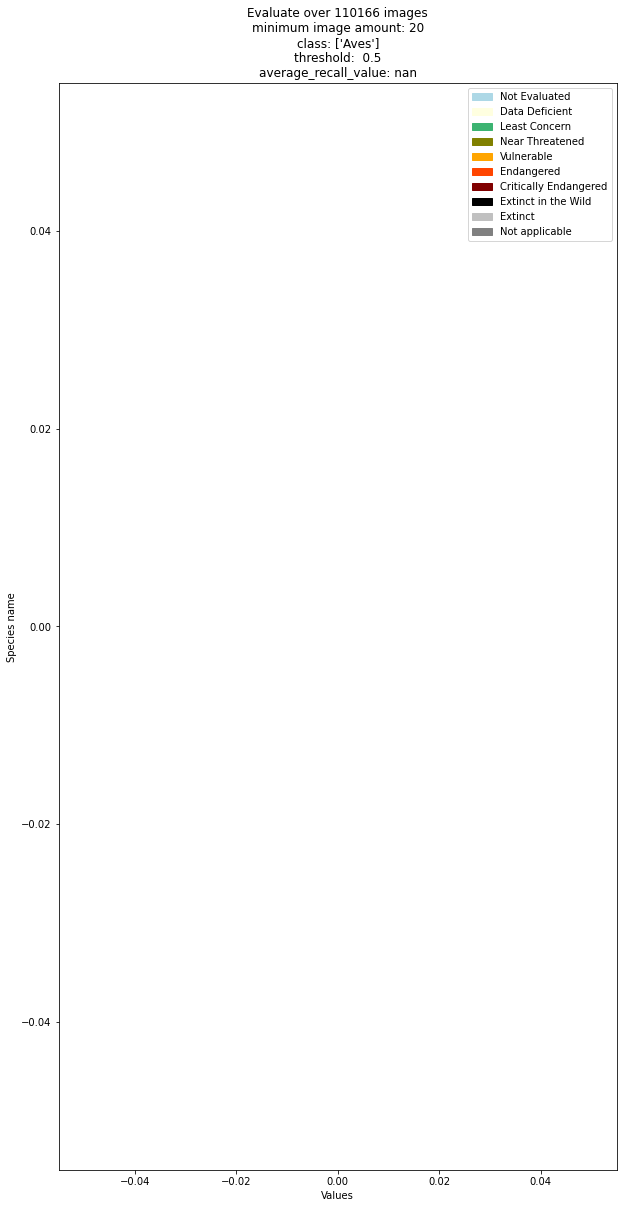

In [ ]:
# read files
ground_truth_table = read_csv_Google_drive(root, ground_truth_folder, ground_truth_file_name)
taxon_match_table = read_csv_Google_drive(root, WI_folder, taxon_match_table_file_name)
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

recall_evaluation(0.5, ['Aves'], ground_truth_table, mega_result, taxon_match_table, in_batch=True)

110166 images
Generating actual and prediction lists...
Reduction rate 0.7772391117605821
Generating confusion matrix...
Generating visualization plot for ['Mammalia', 'Insecta', 'Reptilia']...
     Can not find taxonomy info for Animal
     Can not find taxonomy info for Banded Krait
     Can not find taxonomy info for Black-throated Laughingthrush
     Can not find taxonomy info for Flying Insect
     Can not find taxonomy info for Hill Blue Flycatcher
     Can not find taxonomy info for Impressed Tortoise
     Can not find taxonomy info for Indochinese Wren-babbler
     Can not find taxonomy info for Small Asian Mongoose
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for Macaca nan
     Can not fi

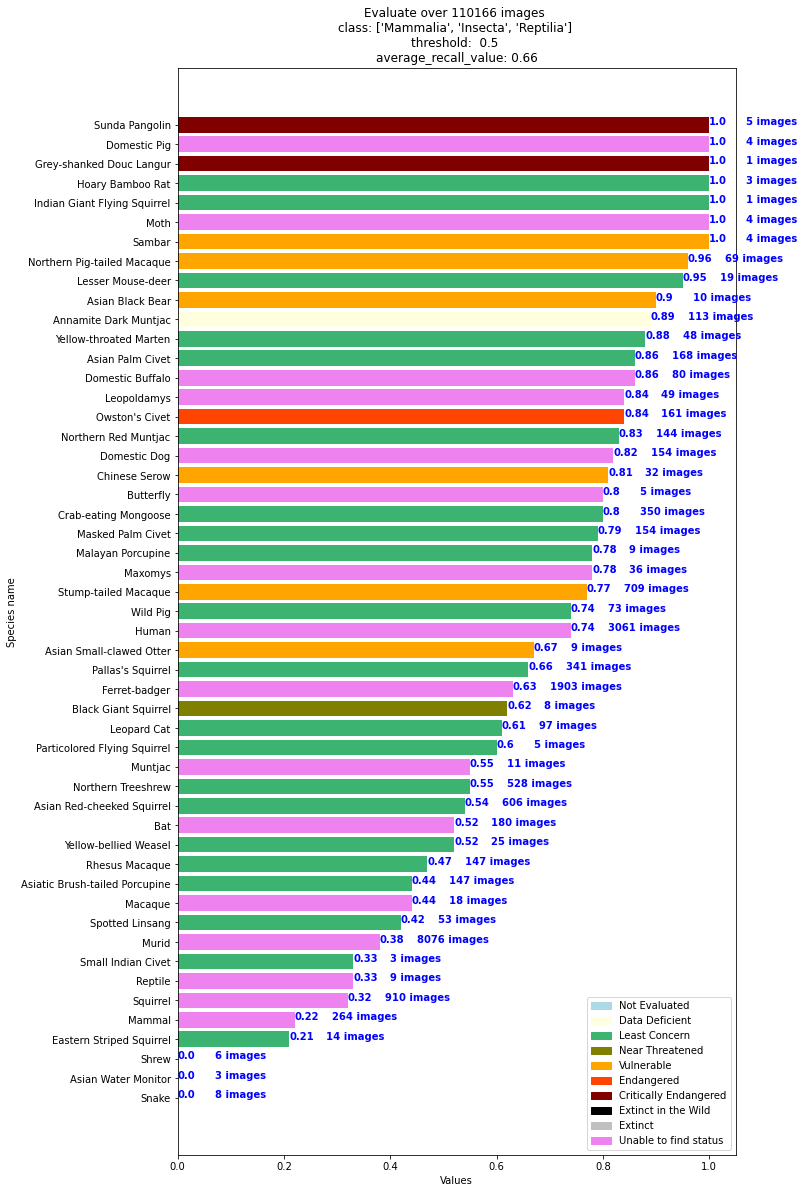

In [ ]:
recall_evaluation(0.5, ['Mammalia', 'Insecta', 'Reptilia'])